In [16]:
import pytraj as pt
import parmed as pmd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import networkx as nx
import scipy 
import plotly.express as px
from scipy import exp
from matplotlib.ticker import MaxNLocator
import math
from scipy.stats import wasserstein_distance
from collections import OrderedDict
from matplotlib.lines import Line2D

NUM_FRAMES = 6000
NUM_RESIDUES = 393
THRESH = 0.002
THRESH_NAME = str(THRESH)[2:]
E_CHANNEL = 0
NUM_PCS = 3
TIME = 5

In [17]:
plt.rcParams['font.family'] = 'Helvetica'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [18]:
#Import the Heat Kernels for each system to be used in pairwise wasserstein analysis
# wt_pcs= pd.read_pickle(f'{FOLDER}/heat_kernels/{FOLDER}_WT_pcs_datatensor.pkl')
# y220c_pcs=pd.read_pickle(f'{FOLDER}/heat_kernels/{FOLDER}_Y220C_pcs_datatensor.pkl')
# pk11000_pcs=pd.read_pickle(f'{FOLDER}/heat_kernels/{FOLDER}_PK11000_pcs_datatensor.pkl')
pcs = {
    "WT": pd.read_csv("/home/student5/Desktop/Energetics/Processed/FL/FL_WT_Long+Short_Elec_1-393.csv"),
    "WT_PK11000": pd.read_csv("/home/student5/Desktop/Energetics/Processed/FL/FL_WT_PK11000_Long+Short_Elec_1-393.csv"),
    "Y220C": pd.read_csv("/home/student5/Desktop/Energetics/Processed/FL/FL_Y220C_Long+Short_Elec_1-393.csv"),
    "Y220C_PK11000": pd.read_csv("/home/student5/Desktop/Energetics/Processed/FL/FL_Y220C_PK11000_Long+Short_Elec_1-393.csv")
}

In [19]:
# def get_var2(dataframe1,dataframe2):
#     divergences = []
#     for i in range(NUM_RESIDUES):
#         x1 = []
#         y1 = []
#         z1 = []
#         x2 = []
#         y2 = []
#         z2 = []
#         for index,row in dataframe1[dataframe1.index==i].iterrows():
#             x1.append(row[0])
#             y1.append(row[1])
#             z1.append(row[2])
#         for index,row in dataframe2[dataframe2.index==i].iterrows():
#             x2.append(row[0])
#             y2.append(row[1])
#             z2.append(row[2])
            
#         d1 = wasserstein_distance(x1,x2)
#         d2 = wasserstein_distance(y1,y2)
#         d3 = wasserstein_distance(z1,z2)
        
# #         print(d1,d2,d3)
        
#         divergences.append(d1 + d2 + d3)

#     return divergences

In [20]:
def get_var2(dataframe1,dataframe2):
    divergences = []
    for i in range(NUM_RESIDUES):
        x1 = []
        y1 = []
        z1 = []
        x2 = []
        y2 = []
        z2 = []
        for index,row in dataframe1[dataframe1["res"]==i+1].iterrows():
            x1.append(row[0])
            y1.append(row[1])
            z1.append(row[2])
        for index,row in dataframe2[dataframe2["res"]==i+1].iterrows():
            x2.append(row[0])
            y2.append(row[1])
            z2.append(row[2])
            
        d1 = wasserstein_distance(x1,x2)
        d2 = wasserstein_distance(y1,y2)
        d3 = wasserstein_distance(z1,z2)
                
        divergences.append(d1 + d2 + d3)

    return divergences

In [21]:
def PlotEE(values, top_ten, title, pic_name):
    plt.rcParams.update({
        'font.family': "Helvetica"
    })
    fig,ax=plt.subplots(figsize=(8,6))
    ax.plot(range(len(values)), values, "-")
    ax.plot(top_ten,".",markersize=10)
    ax.set_xticks([int(x) for x in np.linspace(1, NUM_RESIDUES, 10, endpoint=True)])
    ax.tick_params(axis='x', which='major')
    ax.set_xbound(1,NUM_RESIDUES)
    ax.tick_params(axis='x', which='major')
    ax.set_xlabel('Residue Number', fontsize=15)
    ax.set_ylabel('Embedding Error', fontsize=15)
    ax.set_title(title, fontsize=25)
    line = Line2D([0], [0], label='EE Value', color='#1f77b4')
    point = Line2D([0], [0], label='Top Ten', marker='.', markersize=10,
             markeredgecolor='#ff7f0e', markerfacecolor='#ff7f0e', linestyle='')
    plt.legend(handles=[line, point], borderaxespad=0, bbox_to_anchor=(0.5, -0.15),
               loc="upper center", ncols=4, edgecolor="white", framealpha=0)
#     fig.savefig(pic_name, bbox_inches="tight", dpi=500)
    
def PlotManyEE(values, colors, labels, title, pic_name):
    plt.rcParams.update({
        'font.family': "Helvetica"
    })
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    for value, color, label in zip(values, colors, labels):
        ax.plot(range(NUM_RESIDUES), value, "-", label = label, color = color)

        value_sorted=value.copy()
        value_sorted.sort_values(inplace=True,ascending=False)
        ax.plot(value_sorted[0:10],".",markersize=15, color=color)

    ax.set_xticks([int(x) for x in np.linspace(1, NUM_RESIDUES, 10, endpoint=True)])
    ax.tick_params(axis='x', which='major')
    ax.set_xbound(1,NUM_RESIDUES)
    ax.tick_params(axis='x', which='major')
    ax.set_xlabel('Residue Number', fontsize=15)
    ax.set_ylabel('Embedding Error', fontsize=15)
    ax.set_title(title, fontsize=25)
    fig.legend(borderaxespad=0, bbox_to_anchor=(0.5, 0), loc="upper center", ncols=3, edgecolor="white", framealpha=0)
    fig.savefig(pic_name, bbox_inches="tight", dpi=500, transparent=False, facecolor="white")

            0
337  0.007756
342  0.007176
267  0.007092
110  0.007076
220  0.006981
282  0.006882
158  0.006736
156  0.006574
196  0.006243
273  0.006238


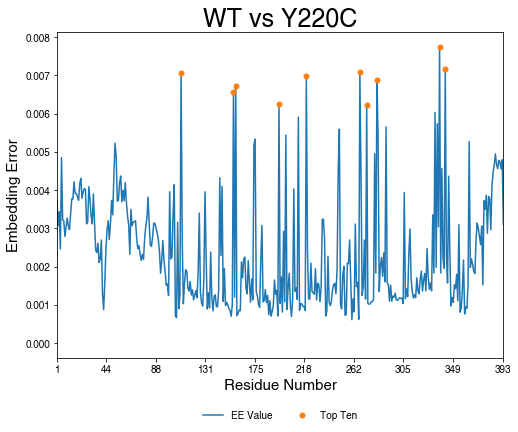

In [22]:
y220c_EE = pd.DataFrame(get_var2(pcs["WT"], pcs["Y220C"]))
y220c_EE_copy = y220c_EE.copy()
top_row = pd.DataFrame([0])
y220c_EE_copy = pd.concat([top_row, y220c_EE_copy]).reset_index(drop = True)
y220c_EE_copy = y220c_EE_copy.values.tolist()

#highlights
df = pd.DataFrame(y220c_EE_copy)
y220c_EE_copy_sorted = df.copy()
y220c_EE_copy_sorted.sort_values(by=[0], inplace=True, ascending=False)
print(y220c_EE_copy_sorted[0:10])

#graph
PlotEE(y220c_EE_copy, y220c_EE_copy_sorted[0:10], "WT vs Y220C", "")

            0
337  0.011796
282  0.011360
342  0.011327
333  0.010871
273  0.010490
290  0.010139
335  0.009843
267  0.009498
283  0.009447
110  0.009429


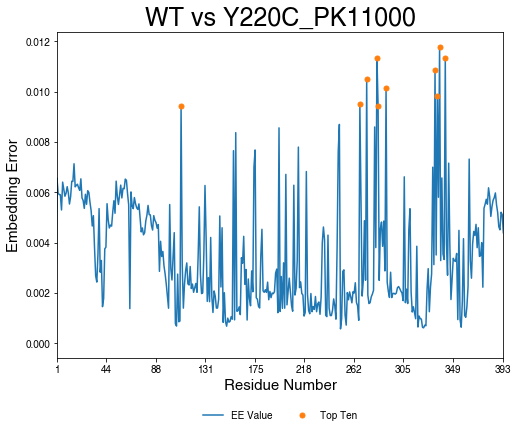

In [23]:
y220c_PK11000_EE = pd.DataFrame(get_var2(pcs["WT"], pcs["Y220C_PK11000"]))
y220c_PK11000_EE_copy = y220c_PK11000_EE.copy()
top_row = pd.DataFrame([0])
y220c_PK11000_EE_copy = pd.concat([top_row, y220c_PK11000_EE_copy]).reset_index(drop = True)
y220c_PK11000_EE_copy = y220c_PK11000_EE_copy.values.tolist()

#highlights
df = pd.DataFrame(y220c_PK11000_EE_copy)
y220c_PK11000_EE_copy_sorted = df.copy()
y220c_PK11000_EE_copy_sorted.sort_values(by=[0], inplace=True, ascending=False)
print(y220c_PK11000_EE_copy_sorted[0:10])

#graph
PlotEE(y220c_PK11000_EE_copy, y220c_PK11000_EE_copy_sorted[0:10], "WT vs Y220C_PK11000", "")

            0
267  0.009231
337  0.008684
342  0.008658
273  0.008442
158  0.008430
282  0.008192
249  0.008017
213  0.007990
333  0.007880
196  0.007759


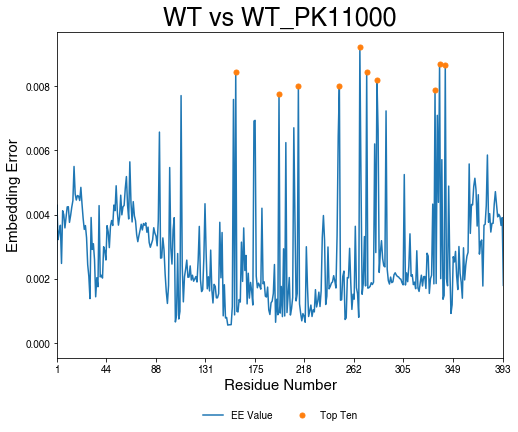

In [24]:
wt_PK11000_EE = pd.DataFrame(get_var2(pcs["WT"], pcs["WT_PK11000"]))
wt_PK11000_EE_copy = wt_PK11000_EE.copy()
top_row = pd.DataFrame([0])
wt_PK11000_EE_copy = pd.concat([top_row, wt_PK11000_EE_copy]).reset_index(drop = True)
wt_PK11000_EE_copy = wt_PK11000_EE_copy.values.tolist()

#highlights
df = pd.DataFrame(wt_PK11000_EE_copy)
wt_PK11000_EE_copy_sorted = df.copy()
wt_PK11000_EE_copy_sorted.sort_values(by=[0], inplace=True, ascending=False)
print(wt_PK11000_EE_copy_sorted[0:10])

#graph
PlotEE(wt_PK11000_EE_copy, wt_PK11000_EE_copy_sorted[0:10], "WT vs WT_PK11000", "")

In [25]:
wt_PK = [x[0] for x in wt_PK11000_EE_copy[1:]]
y220c = [x[0] for x in y220c_EE_copy[1:]]
y220c_PK = [x[0] for x in y220c_PK11000_EE_copy[1:]]
vals = pd.DataFrame({"WT vs Y220C": y220c, "WT vs WT_PK11000": wt_PK, "WT vs Y220C_PK11000": y220c_PK})
avg_vals = vals.mean()

In [26]:
vals['WT vs Y220C'].median()

0.001916433719114726

In [27]:
avg_vals

WT vs Y220C            0.002361
WT vs WT_PK11000       0.002828
WT vs Y220C_PK11000    0.003551
dtype: float64

# Pairwise Embedding Error Analysis

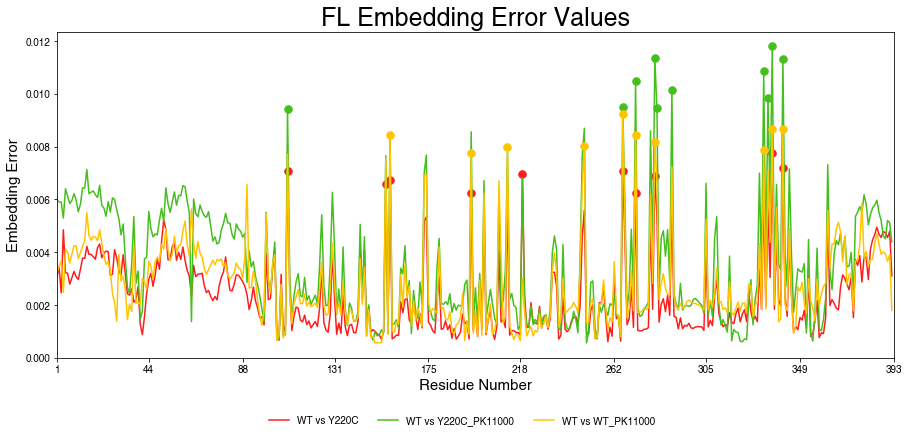

In [28]:
# Plot of ALL Embedding Error Values from Pairwise System Comparisons
PlotManyEE([vals['WT vs Y220C'], vals['WT vs Y220C_PK11000'], vals['WT vs WT_PK11000']], ["#ff1c1c", "#45bf1d", "#ffc400"], 
           ["WT vs Y220C", "WT vs Y220C_PK11000", "WT vs WT_PK11000"], 
           "FL Embedding Error Values", "/home/student5/Desktop/FL_EE2_test.png")

In [13]:
temp = vals['WT vs Y220C_PK11000'] - vals['WT vs Y220C']
" resi ".join(str(x) for x in list(temp.sort_values()[:10].index))

'208 resi 212 resi 173 resi 266 resi 378 resi 157 resi 248 resi 155 resi 195 resi 272'

/tmp/ipykernel_78229/2187176201.py:10: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.savefig("/home/student5/Desktop/EE_Diff2.png", bbox_inches="tight", dpi=500, transparent=False, facecolor="white")


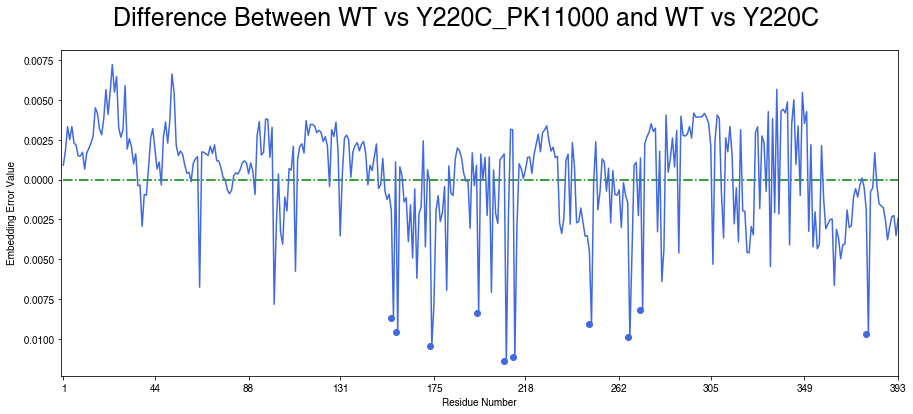

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
ax.hlines(0, 1, 393, color="green", linestyles="-.")
ax.plot(range(1, NUM_RESIDUES+1), vals['WT vs Y220C_PK11000'] - vals['WT vs Y220C'], color="royalblue")
ax.scatter(x = list(temp.sort_values()[:10].index), y = temp.sort_values()[:10], color="royalblue")
ax.set_xlim(0, 393)
ax.set_xticks([int(x) for x in np.linspace(1, NUM_RESIDUES, 10, endpoint=True)])
ax.set_xlabel("Residue Number")
ax.set_ylabel("Embedding Error Value")
fig.suptitle("Difference Between WT vs Y220C_PK11000 and WT vs Y220C", fontsize=25)
fig.savefig("/home/student5/Desktop/EE_Diff2.png", bbox_inches="tight", dpi=500, transparent=False, facecolor="white")

In [11]:
#Addition of Maxes Column to Pairwise Embedding Error Dataframe
'''
#Set each Pairwise Dataframe residue row value
#in 'Maxes' column to which of the Pairwise EE 
#comparisons yielded residue maximum EE value
'''
df3_1dex=df1.set_axis(['WT vs Y220C', 'Y220C vs PK11000', 'WT vs PK11000'], axis=1)
df4_1dex=df3_1dex
df4_1dex["Maxes"]=pd.DataFrame(df4_1dex[:].idxmax(1))
df4_1dex.at[0,'Maxes'] = "Y220C vs PK11000"
df4_1dex[1:NUM_RESIDUES+1]
# df4_1dex.iloc[:, 0:3]

,WT vs Y220C,Y220C vs PK11000,WT vs PK11000,Maxes
1,0.003406,0.006035,0.005944,Y220C vs PK11000
2,0.003218,0.005008,0.001863,Y220C vs PK11000
3,0.003488,0.002858,0.005745,WT vs PK11000
4,0.005627,0.007473,0.003359,Y220C vs PK11000
5,0.003385,0.006408,0.003025,Y220C vs PK11000
...,...,...,...,...
388,0.011693,0.010428,0.003640,WT vs Y220C
389,0.011047,0.009282,0.004783,WT vs Y220C
390,0.014337,0.014214,0.009770,WT vs Y220C
391,0.011675,0.009534,0.005532,WT vs Y220C


In [12]:
APL_PL_maxes=pd.DataFrame(df4_1dex["WT vs Y220C"].copy())
APL_PL_maxes.sort_values(by=["WT vs Y220C"],inplace=True,ascending=False)
APL_PL_maxes[0:20]
lst=APL_PL_maxes[0:20].index.values.tolist() 
print('+'.join(map(str, lst))) 

341+191+332+344+281+385+345+166+357+289+382+392+180+219+342+384+336+163+199+364


In [13]:
df4_1dex.describe()

,WT vs Y220C,Y220C vs PK11000,WT vs PK11000
count,393.000000,393.000000,393.000000
mean,0.007698,0.009758,0.006886
std,0.004090,0.003911,0.003847
min,0.001037,0.001435,0.000536
25%,0.004898,0.006935,0.004210
50%,0.007151,0.009391,0.006144
75%,0.009573,0.012067,0.008813
max,0.029455,0.032521,0.025796


In [14]:
#assign max EE to each residue from all pairwise combs
maxVars_1dex = df4_1dex.iloc[:, 0:3].max(axis = 1)
maxVars_1dex = pd.DataFrame(maxVars_1dex)
maxVars_1dex['Maxes']=df4_1dex['Maxes']
print(maxVars_1dex)

maxVars2_1dex=maxVars_1dex.copy()
#di={"APL_PL":0,"AP_APL":1, "AP_PL":2}
#maxVars2_1dex['Maxes']=maxVars2_1dex['Maxes'].replace(di)
MaxVars2_groups = maxVars2_1dex.groupby('Maxes')

            0             Maxes
0    0.003755  Y220C vs PK11000
1    0.006035  Y220C vs PK11000
2    0.005008  Y220C vs PK11000
3    0.005745     WT vs PK11000
4    0.007473  Y220C vs PK11000
..        ...               ...
388  0.011693       WT vs Y220C
389  0.011047       WT vs Y220C
390  0.014337       WT vs Y220C
391  0.011675       WT vs Y220C
392  0.018372       WT vs Y220C

[393 rows x 2 columns]


In [15]:
maxVars_1dex

,0,Maxes
0,0.003755,Y220C vs PK11000
1,0.006035,Y220C vs PK11000
2,0.005008,Y220C vs PK11000
3,0.005745,WT vs PK11000
4,0.007473,Y220C vs PK11000
...,...,...
388,0.011693,WT vs Y220C
389,0.011047,WT vs Y220C
390,0.014337,WT vs Y220C
391,0.011675,WT vs Y220C


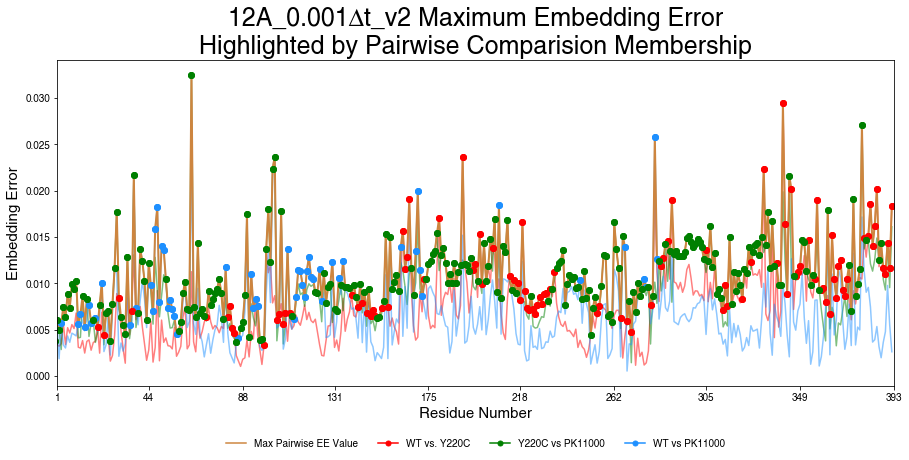

In [29]:
plt.rcParams.update({
    'font.family': "Helvetica"
})
fig,ax=plt.subplots(figsize=(15,6))
ax.plot(df1['WT vs Y220C'], color="red", alpha=0.5)
ax.plot(df1['Y220C vs PK11000'], color="green", alpha=0.5)
ax.plot(df1['WT vs PK11000'], color="dodgerblue", alpha=0.5)
ax.plot(maxVars_1dex[0],marker='o', linestyle='-', markersize=2, color="peru", linewidth=2)
color_dic = {"WT vs Y220C": "red", "Y220C vs PK11000": "green", "WT vs PK11000": "dodgerblue"}
for name, group in MaxVars2_groups:
    for index, value in zip(group[0].keys().tolist(), group[0].tolist()):
        plt.plot([index, index], [value, value], marker='o', color = color_dic[name], label=name)
ax.set_xticks([int(x) for x in np.linspace(1, NUM_RESIDUES, 10, endpoint=True)])
ax.set_xbound(1,NUM_RESIDUES)
ax.tick_params(axis='x', which='major')
ax.legend(bbox_to_anchor=(0.3, 1), loc=0, borderaxespad=0.1,fontsize=12)
ax.set_xlabel('Residue Number', fontsize=15)
ax.set_ylabel('Embedding Error', fontsize=15)
ax.set_title(f'{TITLE} Maximum Embedding Error\nHighlighted by Pairwise Comparision Membership', fontsize=25)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

line = Line2D([0], [0], label='Max Pairwise EE Value', color='peru')
wt_y220cPoint = Line2D([0], [0], label='WT vs. Y220C', marker='.', markersize=10, color="red",
         markeredgecolor='red', markerfacecolor='red', linestyle='-')
y220c_pk11000Point = Line2D([0], [0], label='Y220C vs PK11000', marker='.', markersize=10, color="green",
         markeredgecolor='green', markerfacecolor='green', linestyle='-')
wt_pk11000Point = Line2D([0], [0], label='WT vs PK11000', marker='.', markersize=10, color="dodgerblue",
         markeredgecolor='dodgerblue', markerfacecolor='dodgerblue', linestyle='-')
plt.legend(handles=[line, wt_y220cPoint, y220c_pk11000Point, wt_pk11000Point], borderaxespad=0, bbox_to_anchor=(0.5, -0.15),
           loc="upper center", ncols=4, edgecolor="white", framealpha=0)

# fig.savefig(f"{FOLDER}/Max Embedding Error.jpg", bbox_inches="tight", dpi=500)

In [17]:
for name, group in MaxVars2_groups:
    print(name)
    print(group.transpose().keys().tolist())

WT vs PK11000
[3, 11, 12, 14, 16, 17, 19, 22, 35, 38, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 80, 86, 92, 93, 94, 95, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 124, 125, 130, 133, 135, 162, 169, 170, 171, 172, 208, 246, 267, 276, 277, 281, 282]
WT vs Y220C
[20, 23, 30, 36, 71, 81, 82, 83, 84, 98, 104, 105, 107, 108, 110, 139, 142, 144, 146, 148, 149, 150, 153, 156, 163, 164, 165, 166, 173, 180, 191, 196, 197, 199, 200, 205, 213, 215, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 232, 234, 254, 255, 265, 268, 270, 279, 284, 285, 287, 289, 305, 313, 314, 315, 322, 326, 332, 338, 341, 342, 343, 345, 347, 348, 349, 353, 356, 357, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 379, 381, 382, 383, 384, 385, 388, 389, 390, 391, 392]
Y220C vs PK11000
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 37, 39, 40, 41, 42, 43, 44, 52, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77

In [18]:
percentages = {}
for name, group in MaxVars2_groups:
    percentages |= {name: int(10000*group.shape[0]/NUM_RESIDUES)/100}
percentages

{'WT vs PK11000': 14.24, 'WT vs Y220C': 26.46, 'Y220C vs PK11000': 59.28}

Text(0.5, 1.01, '12A_0.001Δt_v2 Embedding Error Values')

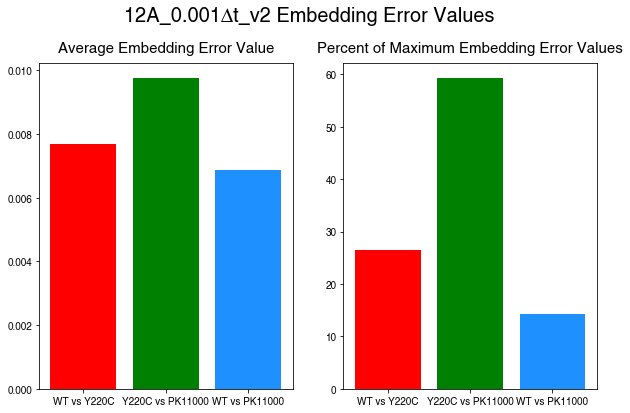

In [19]:
plt.rcParams.update({
    'font.family': "Helvetica"
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.bar(["WT vs Y220C", "Y220C vs PK11000", "WT vs PK11000"], 
        [avg_vals["WT vs Y220C"], avg_vals["Y220C vs PK11000"], avg_vals["WT vs PK11000"]],
        color = ["red", "green", "dodgerblue"])
ax2.bar(["WT vs Y220C", "Y220C vs PK11000", "WT vs PK11000"], 
        [percentages["WT vs Y220C"], percentages["Y220C vs PK11000"], percentages["WT vs PK11000"]],
        color = ["red", "green", "dodgerblue"])
ax1.set_title("Average Embedding Error Value", fontsize=15, pad=10)
ax2.set_title("Percent of Maximum Embedding Error Values", fontsize=15, pad=10)
fig.suptitle(f"{TITLE} Embedding Error Values", fontsize=20, y=1.01)
# fig.savefig(f"{FOLDER}/Embedding Error Bars.jpg", bbox_inches="tight", dpi=500)